In [2]:
# from datagenerator import jet_data_generator 
from datagenerator_realistic import jet_data_generator as realistic_generator

from plotutils import plot_event 
import matplotlib 
import time

In [3]:
import os
import numpy as np
# if not os.path.exists(os.path.join(os.getcwd(),'figures/paper')):
#     os.mkdir(os.path.join(os.getcwd(),'figures/paper'))

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6,6)
plt.rcParams.update({'font.size': 18})

In [5]:
# simple_sig_2p_16part = jet_data_generator("signal",0.00005, 2, 16, True)
realistic_sig_2p_16part = realistic_generator("signal",2, 32, True)

In [6]:
start = time.time()
realisticdata_sig_2p_16part = realistic_sig_2p_16part.generate_dataset(5)
end = time.time()
print(end-start)

event : 0


/n/holystore01/LABS/iaifi_lab/Users/nswood/mambaforge/envs/flat-samples/lib/python3.10/site-packages/pylorentz/__init__.py:34: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self._values = np.array(list(x))
/n/home11/nswood/ToyJetGenerator/datagenerator_realistic.py:327: RuntimeWarning: invalid value encountered in sqrt
  return np.arctan(np.sqrt(num/den))
/n/home11/nswood/ToyJetGenerator/datagenerator_realistic.py:357: RuntimeWarning: invalid value encountered in sqrt
  zmin=np.maximum(0.2/mother.mom.p,0.5*(1-np.sqrt(1-(m/p)**2)))


3.268345594406128


In [7]:
realisticdata_sig_2p_16part[3][0].shape

(36,)

In [30]:
def plot_event(pfcands, name):

    pt = pfcands[:,0]
    eta = pfcands[:,1]
    phi = pfcands[:,2]
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.scatter(eta,phi,s=pt*10, alpha=0.2)
    ax.set_xlabel('eta')
    ax.set_ylabel('phi')
    ax.set_xlim([-1,1])
    ax.set_ylim([-1,1])
    fig.savefig(f'figures/{name}.png')

    
def plot_two_event(pfcand1, pfcand2,augmentation_name):
    # Extract pt, eta, and phi from both events
    pt1 = pfcand1[:,0]
    eta1 = pfcand1[:,1]
    phi1 = pfcand1[:,2]

    pt2 = pfcand2[:,0]
    eta2 = pfcand2[:,1]
    phi2 = pfcand2[:,2]

    # Create subplots with two axes side by side
    fig, axes = plt.subplots(2,1, figsize=(6, 10))

    # Plot the first event
    axes[0].scatter(eta1, phi1, s=pt1*10, alpha=0.2)
    axes[0].set_xlabel('eta')
    axes[0].set_ylabel('phi')
    axes[0].set_xlim([-1, 1])
    axes[0].set_ylim([-1, 1])
    axes[0].set_title(f'Original Jet')

    # Plot the second event
    axes[1].scatter(eta2, phi2, s=pt2*10, alpha=0.2)
    axes[1].set_xlabel('eta')
    axes[1].set_ylabel('phi')
    axes[1].set_xlim([-1, 1])
    axes[1].set_ylim([-1, 1])
    axes[1].set_title(f'{augmentation_name}')

    # Adjust layout and display
    plt.tight_layout()
    plt.show()
#     fig.savefig(f'figures/{name}.png')

In [9]:
import copy
from pylorentz import Momentum4
 
def soft_splitting_augmentation(gen_function, particles_list,n_splits_mid, n_splits_std):
    particles = copy.deepcopy(particles_list)
    n_splittings = int(np.random.normal(loc=n_splits_mid, scale=n_splits_std))
#     print(f'Splitting {n_splittings} particles with soft splitting')
    for _ in range(n_splittings):
        dau1, dau2, z, theta = gen_function.softsplit(particles[0])
        particles.pop(0)
        gen_function.reverse_insort(particles, dau1)
        gen_function.reverse_insort(particles, dau2)
        
    return particles

# new function
# randomly selects root
# merges it with lowest particle energy weighted distance 
def soft_merging_augmentation(gen_function, particles_list,n_merges_mid, n_merges_std):
    particles = copy.deepcopy(particles_list)
    all_e = []
    all_phi = []
    all_eta = []
    for p in particles:
        mom = p.mom
        all_e.append(mom[0])
        all_phi.append(mom.phi)
        all_eta.append(mom.eta)
        
    all_e = np.array(all_e)
    all_phi = np.array(all_phi)
    all_eta = np.array(all_eta)

    phi_diff = (all_phi[:, np.newaxis] - all_phi[np.newaxis, :]).squeeze()
    eta_diff = (all_eta[:, np.newaxis] - all_eta[np.newaxis, :]).squeeze()

    pairwise_matrix = ((phi_diff**2 + eta_diff**2) * (all_e[:, np.newaxis] + all_e[np.newaxis, :]) / 2) + 1000*np.eye(len(particles))
    print(pairwise_matrix.shape)
    n_merges = int(np.random.normal(loc=n_merges_mid, scale=n_merges_std))
    for _ in range(n_merges):
        root = int(np.abs(np.random.normal(loc=0, scale=2)))
        dau2_id = np.argmin(pairwise_matrix[-root])
        
        mother = gen_function.softcombine(particles[-root],particles[dau2_id])
        if root > dau2_id:
            particles.pop(root)
            particles.pop(dau2_id)
        else:
            particles.pop(dau2_id)
            particles.pop(root)
        # need to update pairwise matrix to remove particles dropped and add info for new particles 
#         gen_function.reverse_insort(particles, mother)
        mother_index = gen_function.reverse_insort(particles, mother)
        # Update the pairwise matrix:
        # 1. Remove the rows/columns of the merged particles
        all_e = []
        all_phi = []
        all_eta = []
        for p in particles:
            mom = p.mom
            all_e.append(mom[0])
            all_phi.append(mom.phi)
            all_eta.append(mom.eta)

        all_e = np.array(all_e)
        all_phi = np.array(all_phi)
        all_eta = np.array(all_eta)

        phi_diff = (all_phi[:, np.newaxis] - all_phi[np.newaxis, :]).squeeze()
        eta_diff = (all_eta[:, np.newaxis] - all_eta[np.newaxis, :]).squeeze()

        pairwise_matrix = ((phi_diff**2 + eta_diff**2) * (all_e[:, np.newaxis] + all_e[np.newaxis, :]) / 2) + 1000*np.eye(len(particles))

        
    return particles


def rotation_augmentation(gen_function, particles_list):
    particles = copy.deepcopy(particles_list)
    n_particles = len(particles_list)
    theta = np.random.uniform(low=0,high = np.pi)
#     print(f'Rotating {n_particles} particles')
    for i in range(n_particles):
        rotated_particle_mom = gen_function.rotatePhi(particles[i].mom,theta)
        particles[i].mom = rotated_particle_mom
        
    return particles

def rotation_matrix_x(theta):
    # Create an identity matrix
    rotation_matrix = np.eye(4)
    
    # Set the rotation part for the y-z plane
    rotation_matrix[1, 1] = np.cos(theta)
    rotation_matrix[1, 2] = -np.sin(theta)
    rotation_matrix[2, 1] = np.sin(theta)
    rotation_matrix[2, 2] = np.cos(theta)
    
    return rotation_matrix



def Lorentz_xy_rotation_augmentation(gen_function, particles_list):
    particles = copy.deepcopy(particles_list)
    n_particles = len(particles_list)
    theta = np.random.uniform(low=0,high = 0.5)
    M = rotation_matrix_x(theta)
    print(f'Rotating {n_particles} particles')
    for i in range(n_particles):
        mom = particles[i].mom
        mom_vec = np.array([mom.p_t,mom.p_x,mom.p_y,mom.p_z])
        rotated_mom = M@mom_vec
        new_mom = Momentum4(rotated_mom[0],rotated_mom[1],rotated_mom[2],rotated_mom[3])
        particles[i].mom = new_mom
        
    return particles

def boost_matrix_z(eta):
    # Create an identity matrix
    rotation_matrix = np.eye(4)
    
    # Set the rotation part for the y-z plane
    rotation_matrix[0, 0] = np.cosh(eta)
    rotation_matrix[1, 3] = np.sinh(eta)
    rotation_matrix[0, 3] = np.sinh(eta)
    rotation_matrix[3, 3] = np.cosh(eta)
    
    return rotation_matrix
    
def Lorentz_z_boost_augmentation(gen_function, particles_list):
    particles = copy.deepcopy(particles_list)
    n_particles = len(particles_list)
    eta = np.random.normal(loc=0, scale=0.25)
    M = boost_matrix_z(eta)
    print(f'Rotating {n_particles} particles')
    for i in range(n_particles):
        mom = particles[i].mom
        mom_vec = np.array([mom.p_t,mom.p_x,mom.p_y,mom.p_z])
        boosted_mom = M@mom_vec
        new_mom = Momentum4(boosted_mom[0],boosted_mom[1],boosted_mom[2],boosted_mom[3])
        particles[i].mom = new_mom
        
    return particles  

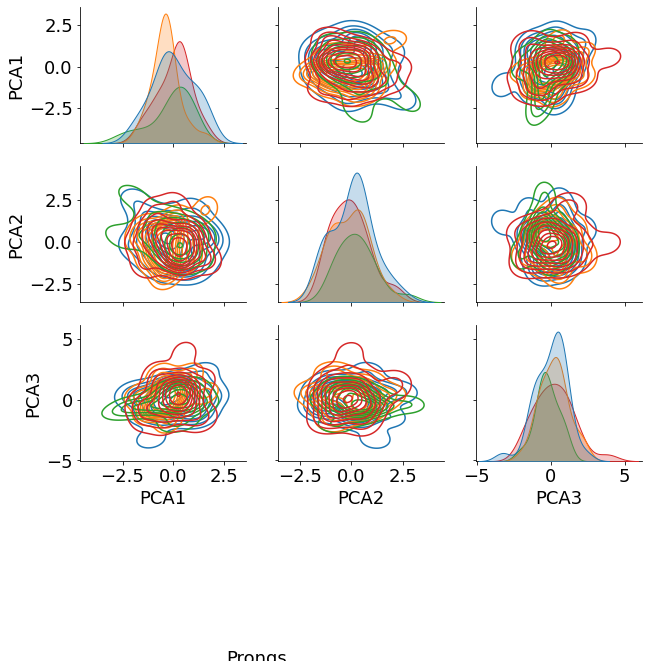

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Create a random test dataframe with some categorical 'Prongs' and numerical values
np.random.seed(42)  # For reproducibility
n_samples = 100
df = pd.DataFrame({
    'PCA1': np.random.randn(n_samples),
    'PCA2': np.random.randn(n_samples),
    'PCA3': np.random.randn(n_samples),
    'Prongs': np.random.choice(['1 Prong', '2 Prong', '3 Prong', '4 Prong'], n_samples)
})



In [56]:
dir(ax._legend)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_agg_filter',
 '_alpha',
 '_animated',
 '_auto_legend_data',
 '_axes',
 '_bbox_to_anchor',
 '_callbacks',
 '_clipon',
 '_clippath',
 '_contains',
 '_custom_handler_map',
 '_default_contains',
 '_default_handler_map',
 '_draggable',
 '_find_best_position',
 '_findoffset',
 '_fontsize',
 '_get_anchored_bbox',
 '_get_clipping_extent_bbox',
 '_get_loc',
 '_gid',
 '_in_layout',
 '_init_legend_box',
 '_label',
 '_legend_box',
 '_legend_handle_box',
 '_legend_title_box',
 '_loc',
 '_loc_real',
 '_loc_used_default',
 '_mode',
 '_mouseover',
 '_ncol',
 '_path_effects',
 '_picker',
 '_rasterized',
 '_remove_method

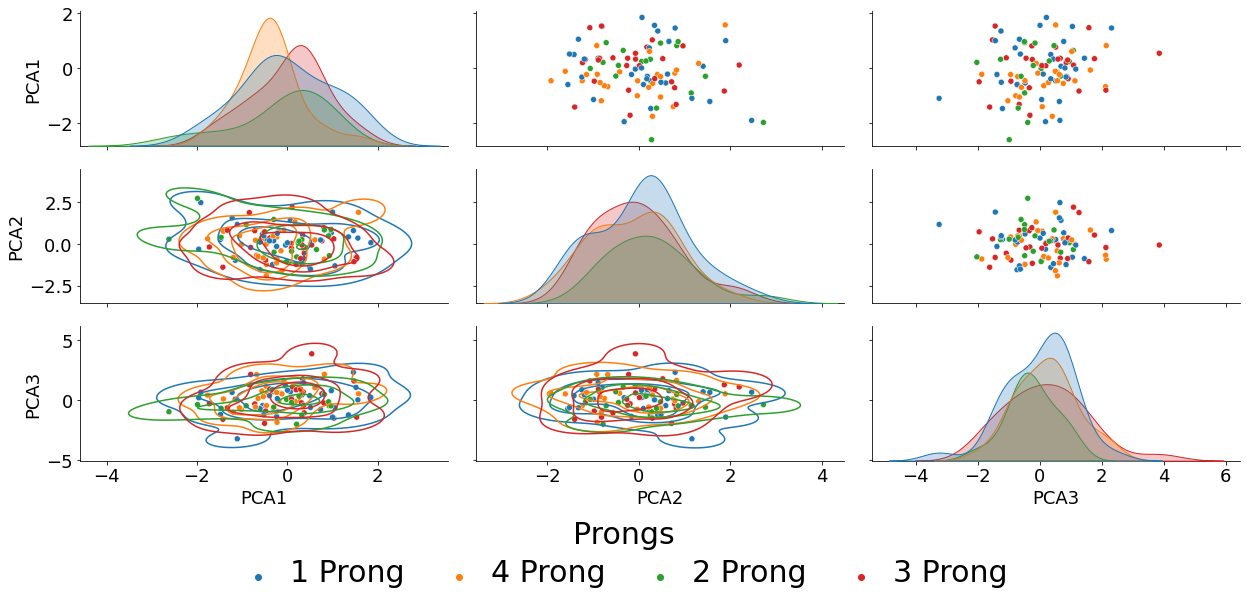

In [59]:
# Create the pairplot and keep the default legend
ax = sns.pairplot(df, hue='Prongs', kind="scatter", palette='tab10', diag_kind='kde')
ax._legend.remove()

# Move the legend using the underlying Matplotlib API
ax.add_legend(title="Prongs", bbox_to_anchor=(0.5, -0.05), loc='center', ncol=4, frameon=False)
# Adjust the font size for the legend
ax.map_lower(sns.kdeplot, levels=4, color=".2")
plt.setp(ax._legend.get_texts(), fontsize='30')
plt.setp(ax._legend.get_title(), fontsize='30')

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()


Datasets in the file: ['aug_data', 'data']


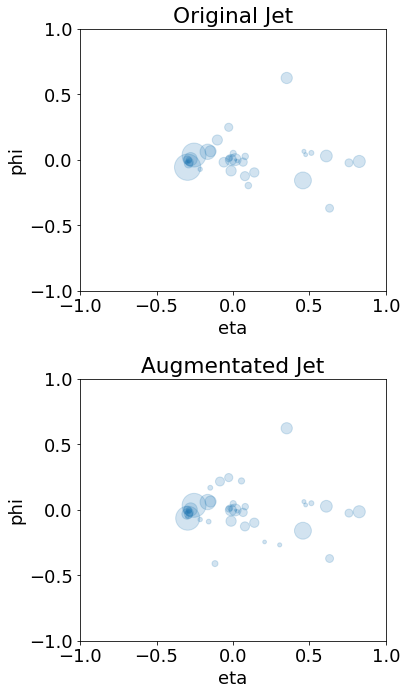

In [80]:
import h5py
with h5py.File('test_data/jet_2_0.h5', 'r') as f:
    # List all datasets in the file
    print("Datasets in the file:", list(f.keys()))
    
    # Load the datasets
    data = f['data'][:]
    aug_data = f['aug_data'][:]

index = np.random.randint(0,1000)    
plot_two_event(data[index].reshape(-1,3),aug_data[index].reshape(-1,3),'Augmentated Jet')

Rotating 28 particles


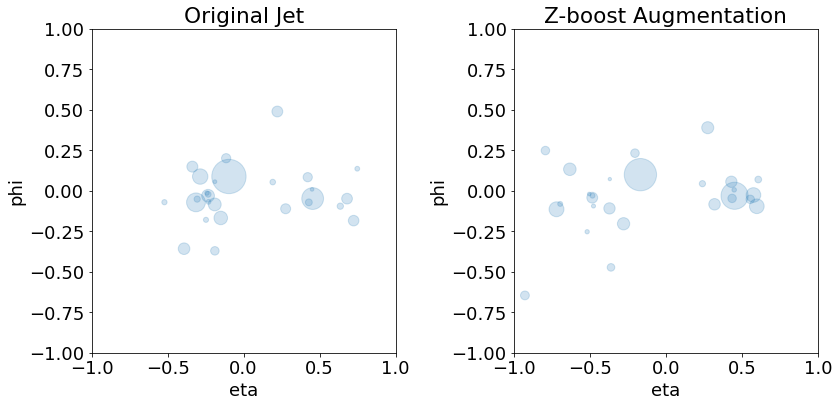

In [125]:
import numpy as np
original_jet = realisticdata_sig_2p_16part[0][0].reshape(-1,3)

augmented_jet = Lorentz_z_boost_augmentation(realistic_sig_2p_16part,list(realisticdata_sig_2p_16part[3][0]))
augmented_arr = []
for j in range(len(augmented_jet)):
    augmented_arr.append(augmented_jet[j].mom.p_t)
    augmented_arr.append(augmented_jet[j].mom.eta)
    augmented_arr.append(augmented_jet[j].mom.phi)
augmented_arr = np.array(augmented_arr)

plot_two_event(original_jet,augmented_arr.reshape(-1,3),'Z-boost Augmentation')

Rotating 28 particles


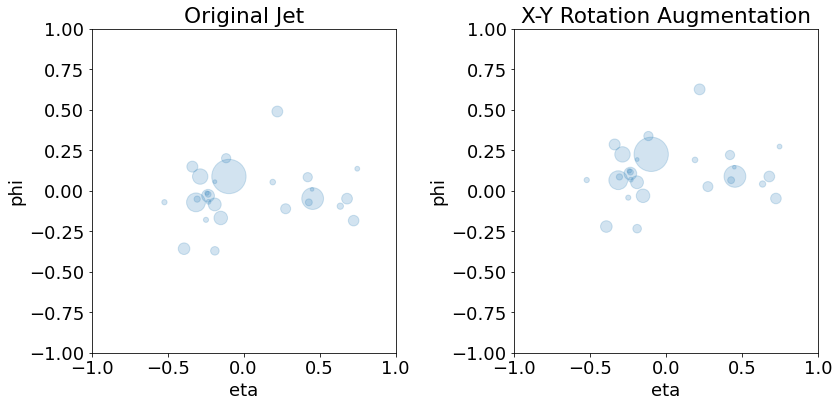

In [134]:

import numpy as np
original_jet = realisticdata_sig_2p_16part[0][0].reshape(-1,3)

augmented_jet = Lorentz_xy_rotation_augmentation(realistic_sig_2p_16part,list(realisticdata_sig_2p_16part[3][0]))
augmented_arr = []
for j in range(len(augmented_jet)):
    augmented_arr.append(augmented_jet[j].mom.p_t)
    augmented_arr.append(augmented_jet[j].mom.eta)
    augmented_arr.append(augmented_jet[j].mom.phi)
augmented_arr = np.array(augmented_arr)

plot_two_event(original_jet,augmented_arr.reshape(-1,3),'X-Y Rotation Augmentation')

In [ ]:
import numpy as np
original_jet = realisticdata_sig_2p_16part[0][0].reshape(-1,3)

augmented_jet = Lorentz_z_boost_augmentation(realistic_sig_2p_16part,list(realisticdata_sig_2p_16part[3][0]))
augmented_arr = []
for j in range(len(augmented_jet)):
    augmented_arr.append(augmented_jet[j].mom.p_t)
    augmented_arr.append(augmented_jet[j].mom.eta)
    augmented_arr.append(augmented_jet[j].mom.phi)
augmented_arr = np.array(augmented_arr)

plot_two_event(original_jet,augmented_arr.reshape(-1,3),'Z-boost Augmentation')

(28, 28)
9
27
(27, 27)
13
26
(26, 26)
4
25
(25, 25)
19
24
(24, 24)
1
23
(23, 23)
22
22
(22, 22)


/n/holystore01/LABS/iaifi_lab/Users/nswood/mambaforge/envs/flat-samples/lib/python3.10/site-packages/pylorentz/__init__.py:34: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self._values = np.array(list(x))


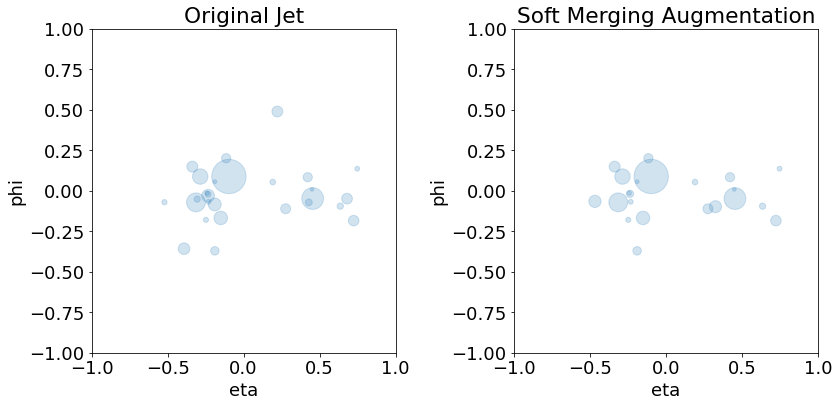

In [107]:
import numpy as np
original_jet = realisticdata_sig_2p_16part[0][0].reshape(-1,3)

augmented_jet = soft_merging_augmentation(realistic_sig_2p_16part,list(realisticdata_sig_2p_16part[3][0]),5,2)
augmented_arr = []
for j in range(len(augmented_jet)):
    augmented_arr.append(augmented_jet[j].mom.p_t)
    augmented_arr.append(augmented_jet[j].mom.eta)
    augmented_arr.append(augmented_jet[j].mom.phi)
augmented_arr = np.array(augmented_arr)

plot_two_event(original_jet,augmented_arr.reshape(-1,3),'Soft Merging Augmentation')

In [24]:
def apply_augmentation(gen_function,data,aug_fn):
    
    augmented_jet = aug_fn(gen_function,list(data),5,2)
    augmented_arr = []
    for j in range(len(augmented_jet)):
        augmented_arr.append(augmented_jet[j].mom.p_t)
        augmented_arr.append(augmented_jet[j].mom.eta)
        augmented_arr.append(augmented_jet[j].mom.phi)
    augmented_arr = np.array(augmented_arr)
    return augmented_arr


In [22]:
import random
def gen_data_pairs(out_dir, n_prongs, n_samples,n_parts, functions):
    gen_function = realistic_generator("signal",n_prongs, n_parts, True)
    data_arr,_,_,data_particles = gen_function.generate_dataset(n_samples)
    aug_arr = []
    for d in data_particles:
        cur_fun = random.choice(functions)
        cur_aug_arr = apply_augmentation(gen_function, d,cur_fun)
        aug_arr.append(cur_aug_arr)
    return data_arr, aug_arr
        
    
    

In [68]:
data, aug_data = gen_data_pairs('',
               1,
               10,
               24,
#                [soft_splitting_augmentation,soft_merging_augmentation]
               [soft_merging_augmentation]
               )


event : 0


KeyboardInterrupt: 

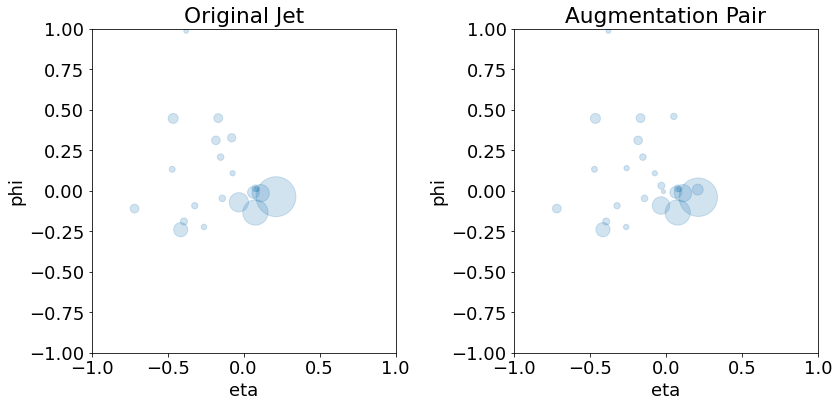

In [238]:
plot_two_event(data[0].reshape(-1,3),aug_data[0].reshape(-1,3),'Augmentation Pair')

In [244]:
n_parts = np. 
realisticdata_sig_2p_16part[3].shape

(2, 32)

Rotating 32 particles


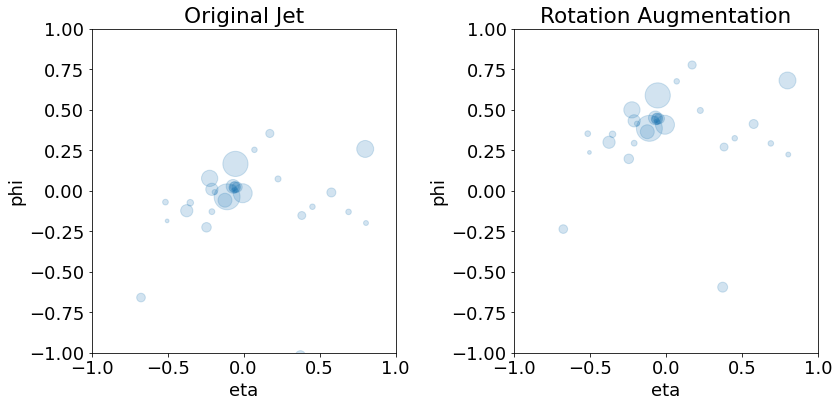

In [123]:
original_jet = realisticdata_sig_2p_16part[0][0].reshape(-1,3)

augmented_jet = Lorentz_xy_rotation_augmentation(realistic_sig_2p_16part,list(realisticdata_sig_2p_16part[3][0]))
augmented_arr = []
for j in range(len(augmented_jet)):
    augmented_arr.append(augmented_jet[j].mom.p_t)
    augmented_arr.append(augmented_jet[j].mom.eta)
    augmented_arr.append(augmented_jet[j].mom.phi)
augmented_arr = np.array(augmented_arr)

plot_two_event(original_jet,augmented_arr.reshape(-1,3),'Rotation Augmentation')

Splitting 12 particles with soft splitting


/n/home11/nswood/ToyJetGenerator/datagenerator_realistic.py:326: RuntimeWarning: invalid value encountered in sqrt
  return np.arctan(np.sqrt(num/den))


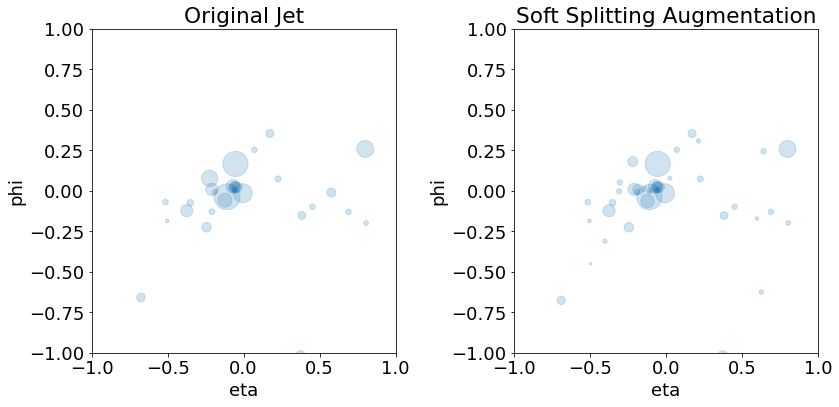

In [122]:
original_jet = realisticdata_sig_2p_16part[0][0].reshape(-1,3)

augmented_jet = soft_splitting_augmentation(realistic_sig_2p_16part,list(realisticdata_sig_2p_16part[3][0]),10,2)
augmented_arr = []
for j in range(len(augmented_jet)):
    augmented_arr.append(augmented_jet[j].mom.p_t)
    augmented_arr.append(augmented_jet[j].mom.eta)
    augmented_arr.append(augmented_jet[j].mom.phi)
augmented_arr = np.array(augmented_arr)

plot_two_event(original_jet,augmented_arr.reshape(-1,3),'Soft Splitting Augmentation')

Splitting 9 particles with soft splitting
Rotating 41 particles


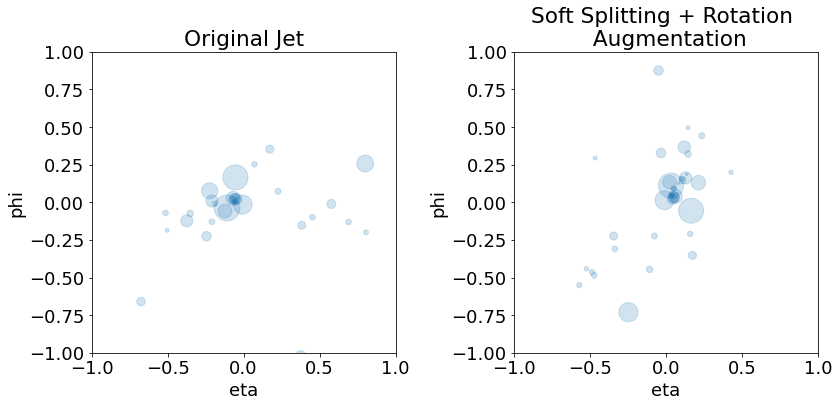

In [49]:
original_jet = realisticdata_sig_2p_16part[0][0].reshape(-1,3)

augmented_jet1 = soft_splitting_augmentation(realistic_sig_2p_16part,list(realisticdata_sig_2p_16part[3][0]),10,2)
augmented_jet = rotation_augmentation(realistic_sig_2p_16part,augmented_jet1)
augmented_arr = []
for j in range(len(augmented_jet)):
    augmented_arr.append(augmented_jet[j].mom.p_t)
    augmented_arr.append(augmented_jet[j].mom.eta)
    augmented_arr.append(augmented_jet[j].mom.phi)
augmented_arr = np.array(augmented_arr)

plot_two_event(original_jet,augmented_arr.reshape(-1,3),'Soft Splitting + Rotation \n Augmentation')

Combining 6 particles with soft splitting
Rotating 26 particles


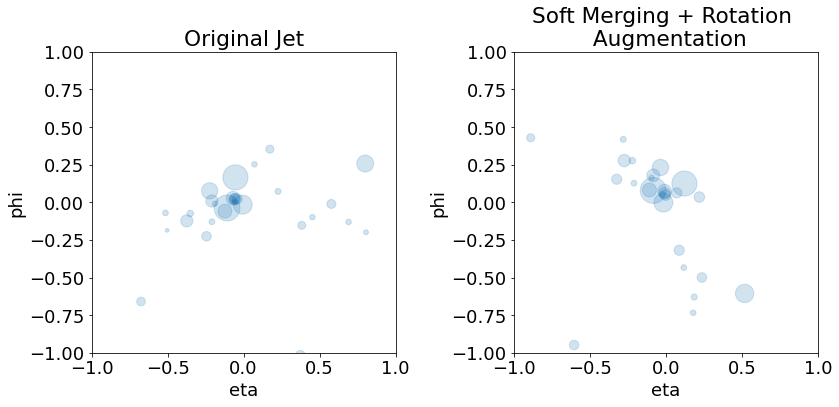

In [50]:
original_jet = realisticdata_sig_2p_16part[0][0].reshape(-1,3)

augmented_jet1 = soft_merging_augmentation(realistic_sig_2p_16part,list(realisticdata_sig_2p_16part[3][0]),10,2)
augmented_jet = rotation_augmentation(realistic_sig_2p_16part,augmented_jet1)
augmented_arr = []
for j in range(len(augmented_jet)):
    augmented_arr.append(augmented_jet[j].mom.p_t)
    augmented_arr.append(augmented_jet[j].mom.eta)
    augmented_arr.append(augmented_jet[j].mom.phi)
augmented_arr = np.array(augmented_arr)

plot_two_event(original_jet,augmented_arr.reshape(-1,3),'Soft Merging + Rotation \n Augmentation')

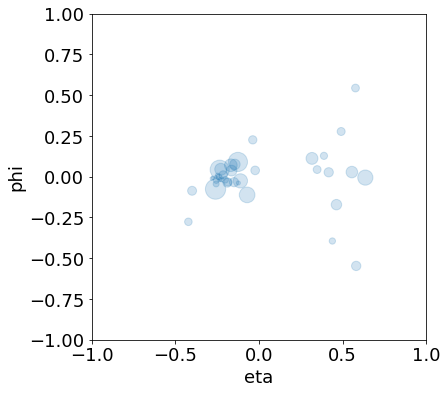

In [80]:
plot_event(original_jet,arr.reshape(-1,3))

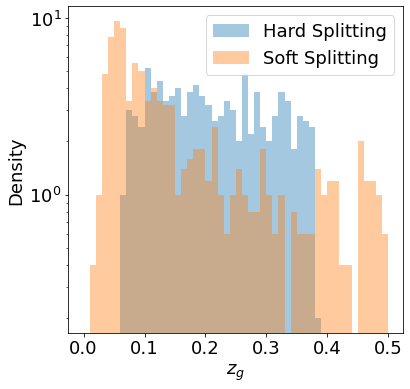

In [19]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(realisticdata_sig_2p_16part[1][:,0],alpha=0.4,bins=np.linspace(0,0.5,51),density=True,label="Hard Splitting")
ax.hist(realisticdata_sig_2p_16part[1][:,1],alpha=0.4,bins=np.linspace(0,0.5,51),density=True,label="Soft Splitting")
ax.legend()
ax.set_xlabel(r'$z_{g}$')
ax.set_ylabel('Density')
ax.set_yscale('log')
#fig.savefig('./figures/paper/realistic_toyjet_momentum_sharing_Log.png')
#fig.savefig('./figures/paper/realistic_toyjet_momentum_sharing_Log.pdf')

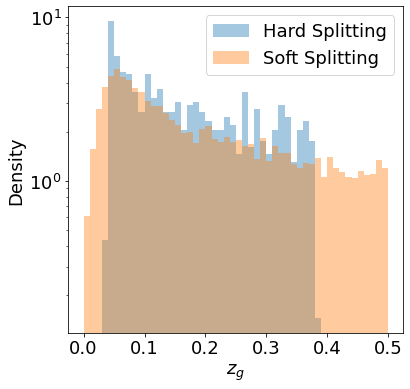

In [20]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(realistic_sig_2p_16part.zhard,alpha=0.4,bins=np.linspace(0,0.5,51),density=True,label="Hard Splitting")
ax.hist(realistic_sig_2p_16part.zsoft,alpha=0.4,bins=np.linspace(0,0.5,51),density=True,label="Soft Splitting")
ax.legend()
ax.set_xlabel(r'$z_{g}$')
ax.set_ylabel('Density')
ax.set_yscale('log')
fig.savefig('./figures/paper/realistic_toyjet_momentum_sharing_Log.png')
fig.savefig('./figures/paper/realistic_toyjet_momentum_sharing_Log.pdf')

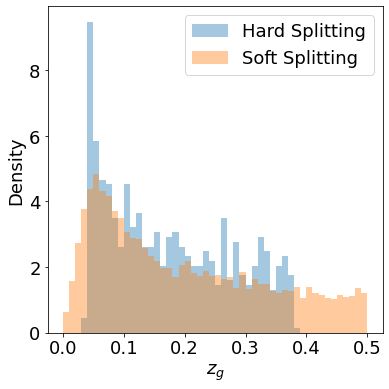

In [21]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(realistic_sig_2p_16part.zhard,alpha=0.4,bins=np.linspace(0,0.5,51),density=True,label="Hard Splitting")
ax.hist(realistic_sig_2p_16part.zsoft,alpha=0.4,bins=np.linspace(0,0.5,51),density=True,label="Soft Splitting")
ax.legend()
ax.set_xlabel(r'$z_{g}$')
ax.set_ylabel('Density')
fig.savefig('./figures/paper/realistic_toyjet_momentum_sharing.png')
fig.savefig('./figures/paper/realistic_toyjet_momentum_sharing.pdf')

In [22]:
import matplotlib as mpl
import matplotlib.font_manager as font_manager

mpl.rcParams['font.family']='serif'
cmfont = font_manager.FontProperties(fname=mpl.get_data_path() + '/fonts/ttf/cmr10.ttf')
mpl.rcParams['font.serif']=cmfont.get_name()
mpl.rcParams['mathtext.fontset']='cm'
mpl.rcParams['axes.unicode_minus']=False
mpl.rcParams['figure.dpi'] = 300
import matplotlib.pyplot as plt

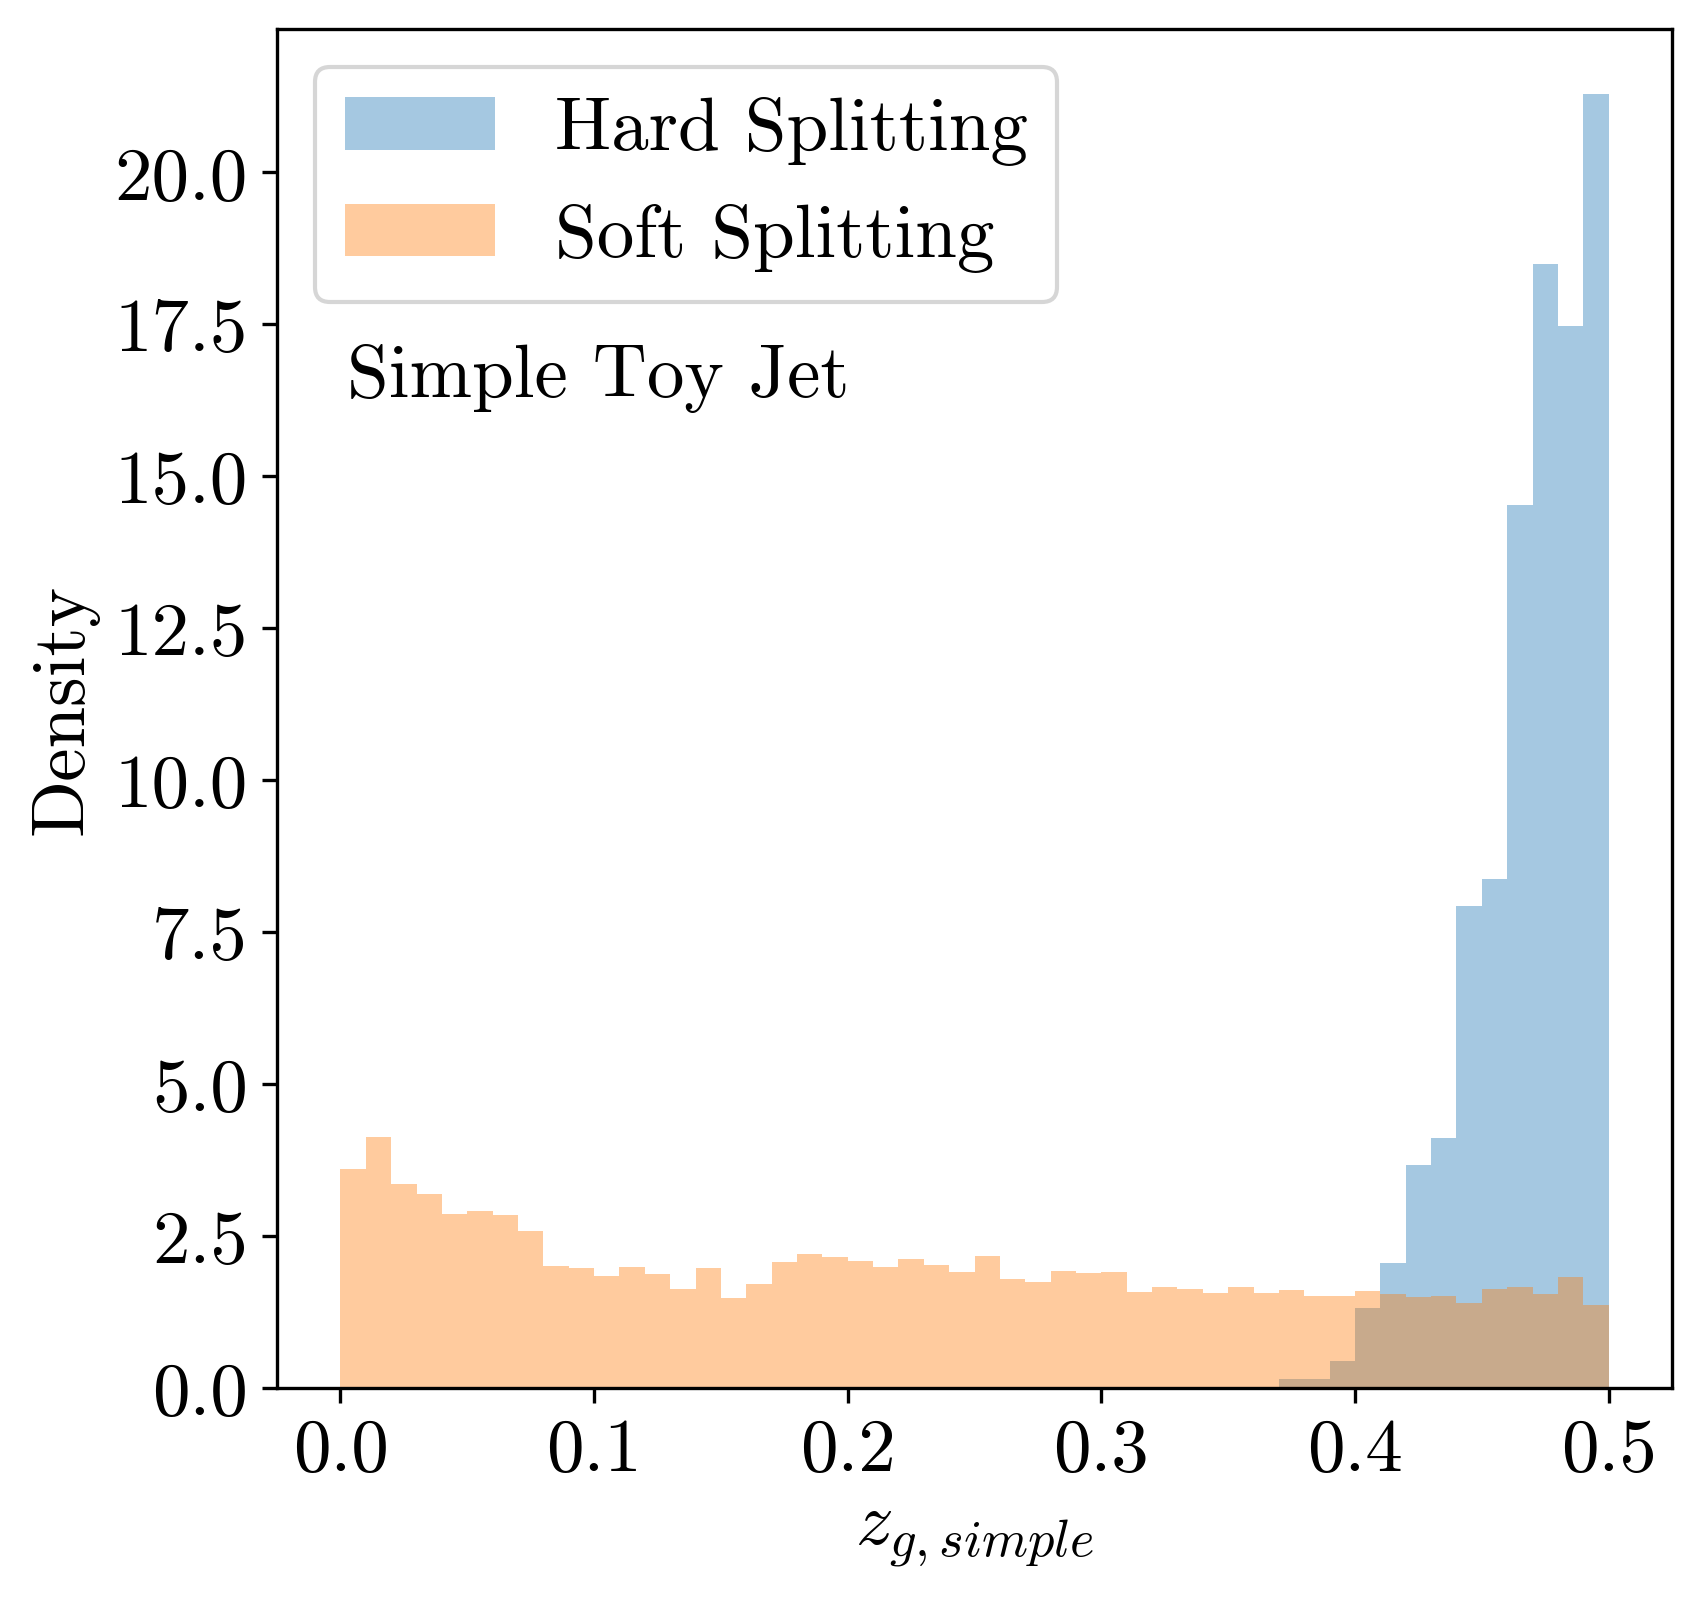

In [23]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(simple_sig_2p_16part.zhard,alpha=0.4,bins=np.linspace(0,0.5,51),density=True,label="Hard Splitting")
ax.hist(simple_sig_2p_16part.zsoft,alpha=0.4,bins=np.linspace(0,0.5,51),density=True,label="Soft Splitting")
ax.legend()
ax.set_xlabel(r'$z_{g, simple}$')
ax.set_ylabel('Density')
ax.text(0.05, 0.73, 'Simple Toy Jet', transform=ax.transAxes)

fig.savefig('./figures/paper_JHEP/SimpleToyJet_Zg.png')
fig.savefig('./figures/paper_JHEP/SimpleToyJet_Zg.pdf')

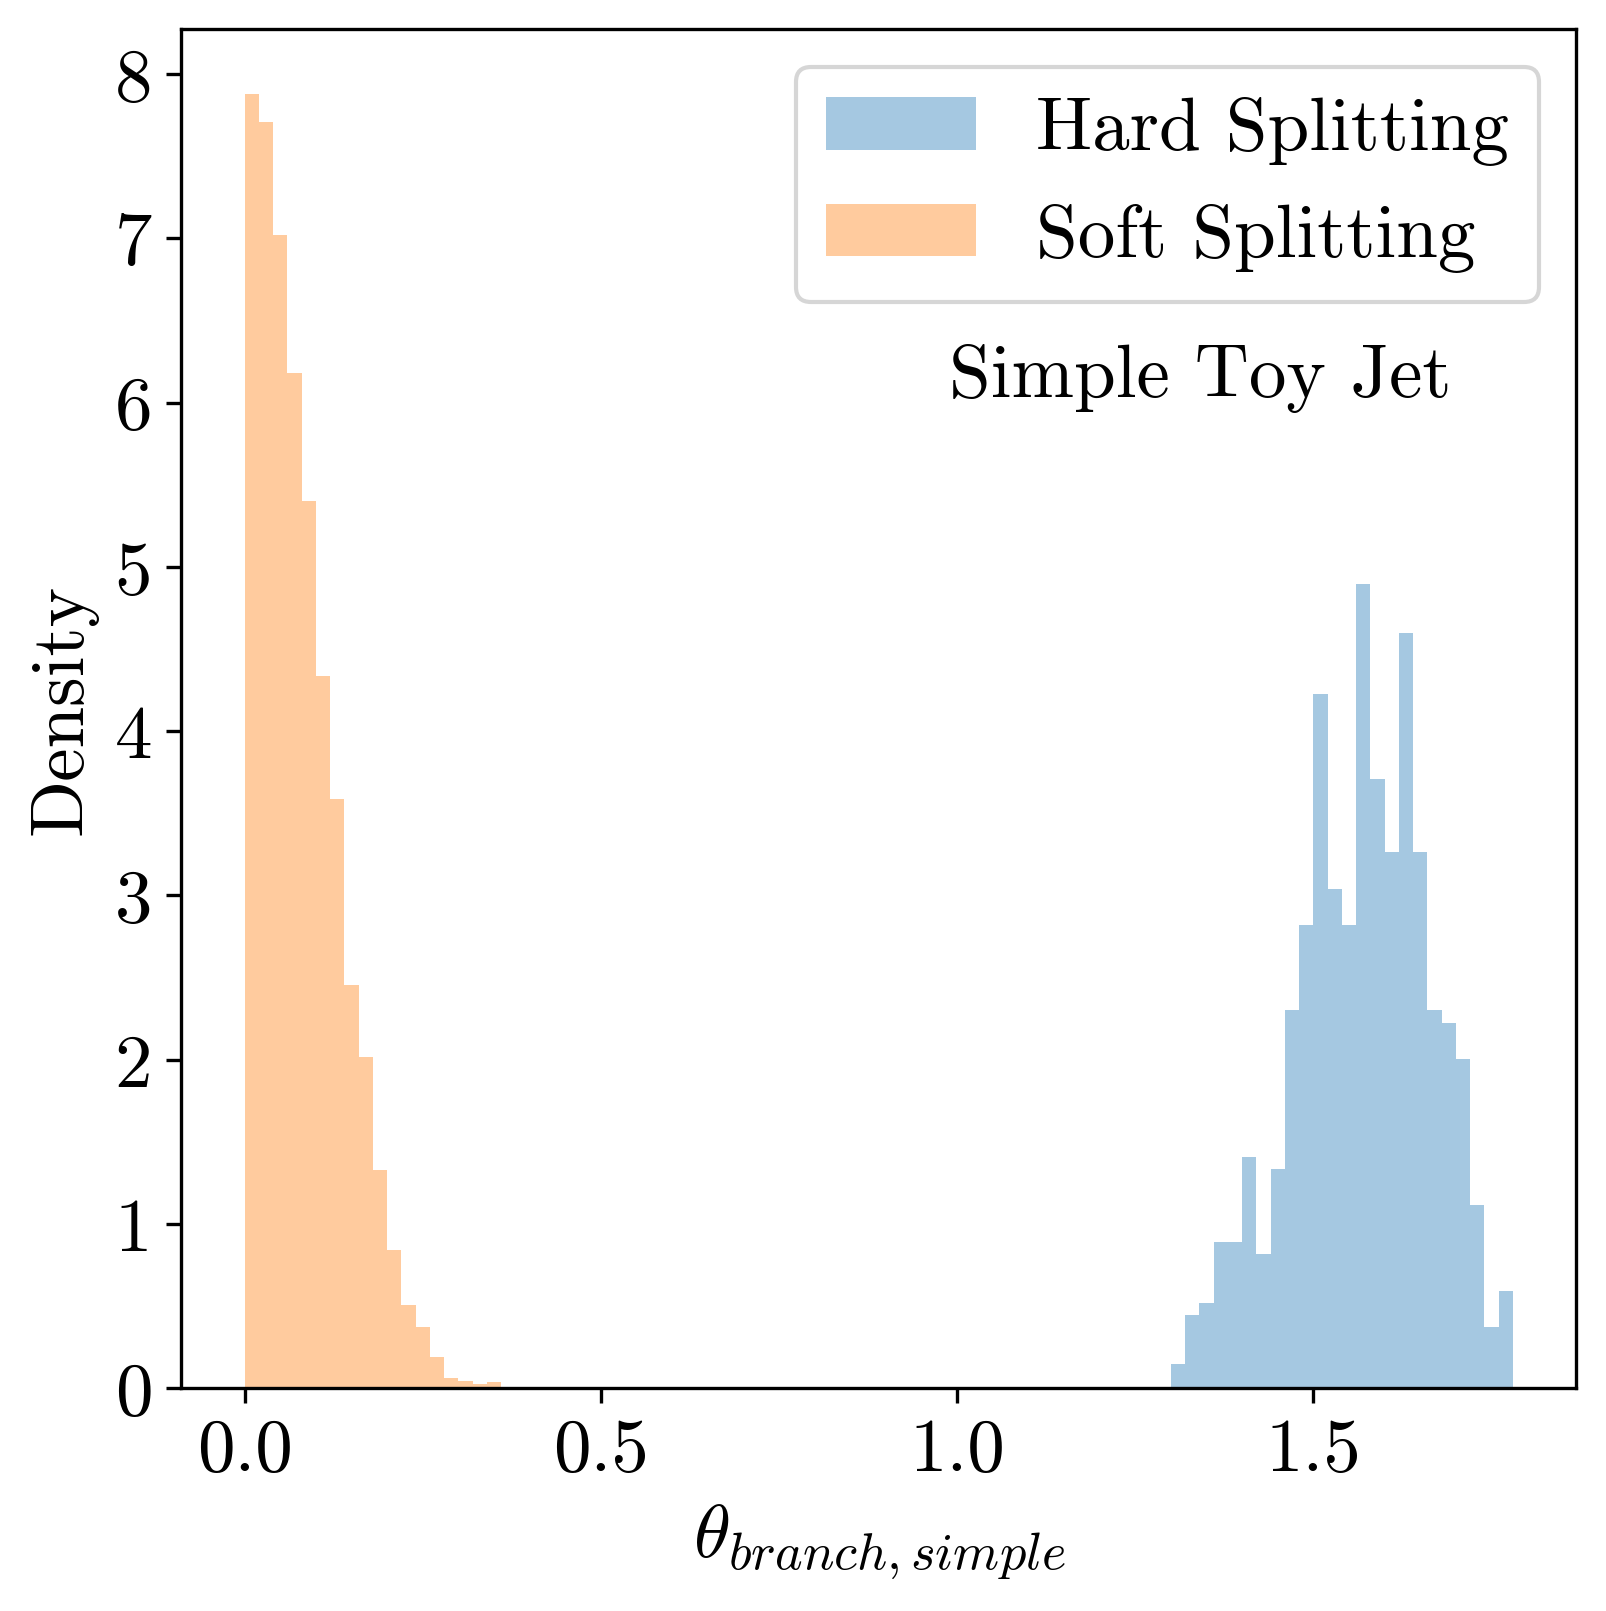

In [24]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(simple_sig_2p_16part.thetahard,alpha=0.4,bins=np.arange(0,1.8,0.02),density=True,label="Hard Splitting")
ax.hist(simple_sig_2p_16part.thetasoft,alpha=0.4,bins=np.arange(0,1.8,0.02),density=True,label="Soft Splitting")
ax.legend()
ax.set_xlabel(r'$\theta_{branch, simple}$')
ax.set_ylabel('Density')
ax.text(0.55, 0.73, 'Simple Toy Jet', transform=ax.transAxes)

fig.savefig('./figures/paper_JHEP/SimpleToyJet_Theta.png')
fig.savefig('./figures/paper_JHEP/SimpleToyJet_Theta.pdf')

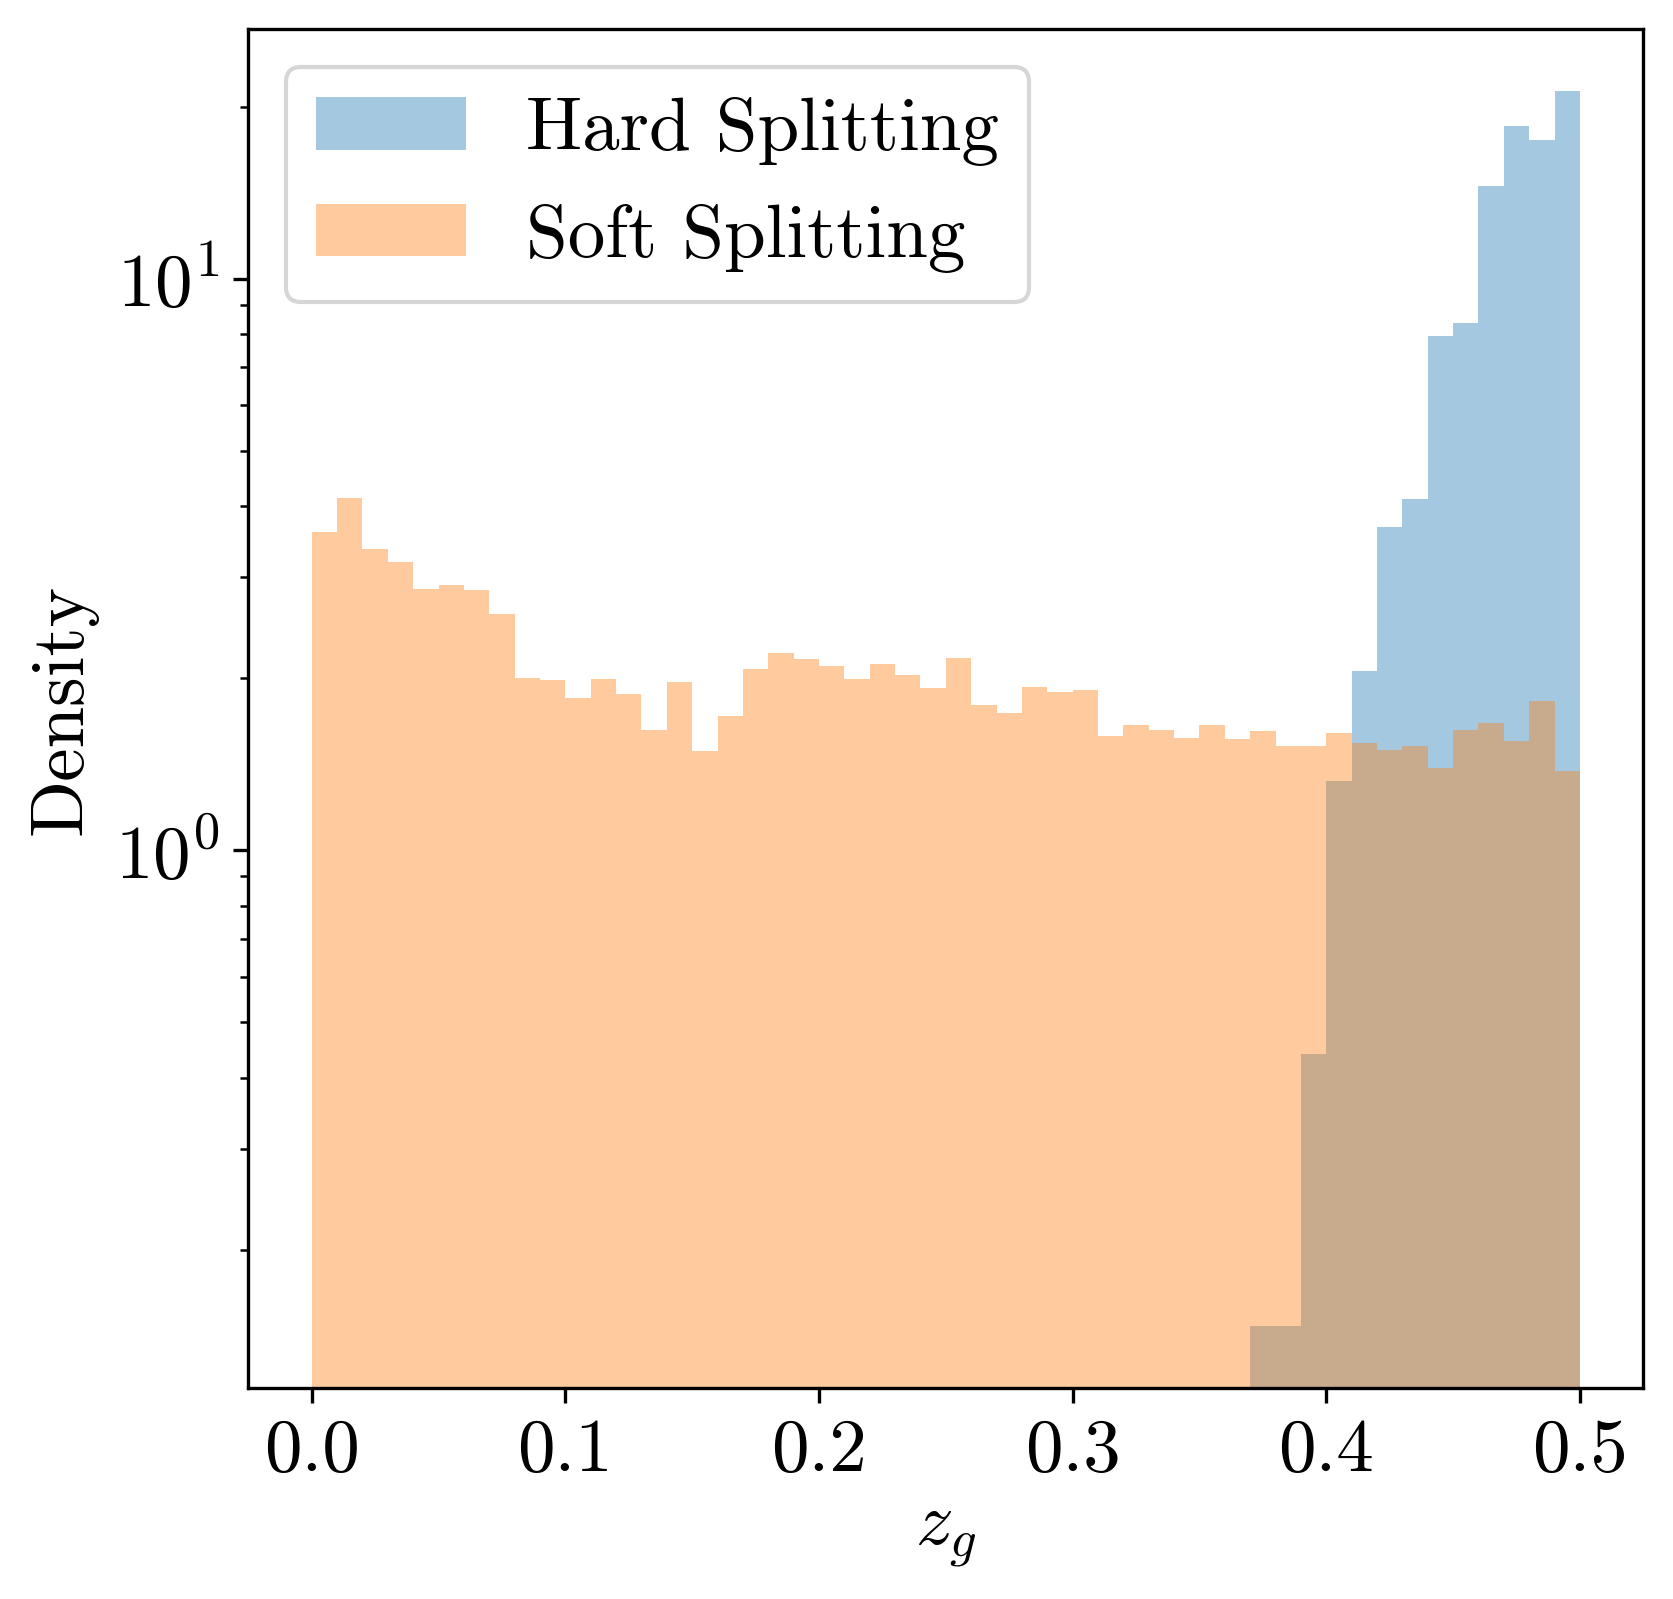

In [25]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(simple_sig_2p_16part.zhard,alpha=0.4,bins=np.linspace(0,0.5,51),density=True,label="Hard Splitting")
ax.hist(simple_sig_2p_16part.zsoft,alpha=0.4,bins=np.linspace(0,0.5,51),density=True,label="Soft Splitting")
ax.legend()
ax.set_xlabel(r'$z_{g}$')
ax.set_ylabel('Density')
ax.set_yscale('log')

fig.savefig('./figures/paper/simple_toyjet_momentum_sharing_Log.png')
fig.savefig('./figures/paper/simple_toyjet_momentum_sharing_Log.pdf')

Text(0, 0.5, 'Density')

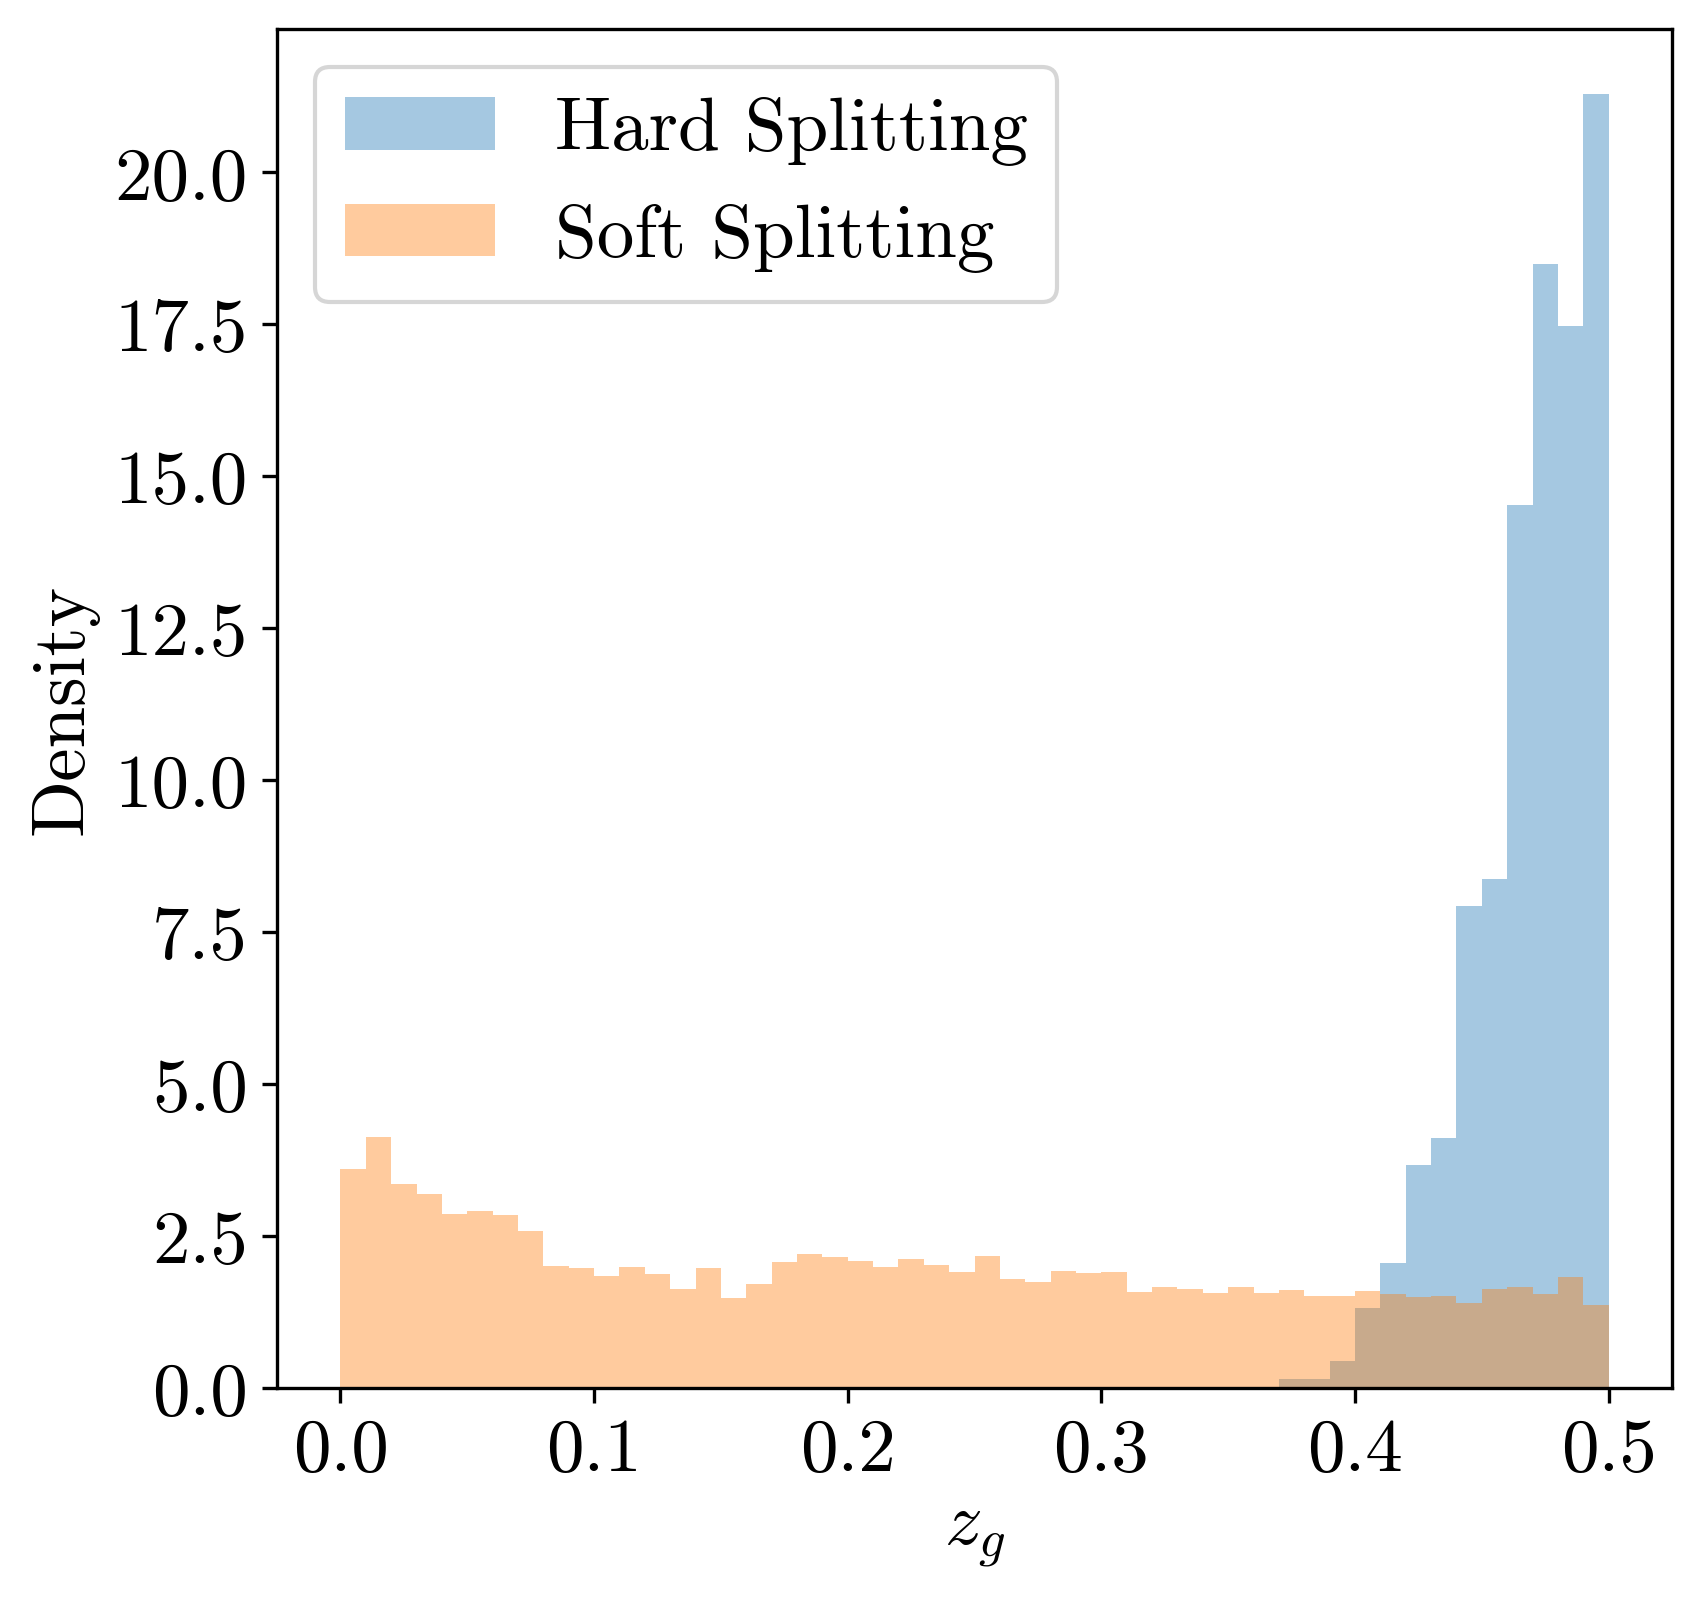

In [26]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(simple_sig_2p_16part.zhard,alpha=0.4,bins=np.linspace(0,0.5,51),density=True,label="Hard Splitting")
ax.hist(simple_sig_2p_16part.zsoft,alpha=0.4,bins=np.linspace(0,0.5,51),density=True,label="Soft Splitting")
ax.legend()
ax.set_xlabel(r'$z_{g}$')
ax.set_ylabel('Density')
#fig.savefig('./figures/paper/simple_toyjet_momentum_sharing.png')
#fig.savefig('./figures/paper/simple_toyjet_momentum_sharing.pdf')

In [27]:
data_sig_2p_8part.shape

NameError: name 'data_sig_2p_8part' is not defined

In [48]:
def plot_event(pfcands, name):

    pt = pfcands[:,0]
    eta = pfcands[:,1]
    phi = pfcands[:,2]
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.scatter(eta,phi,s=pt*10, alpha=0.2)
    ax.set_xlabel('eta')
    ax.set_ylabel('phi')
    ax.set_xlim([-1,1])
    ax.set_ylim([-1,1])
    fig.savefig(f'figures/{name}.png')
plot_event(data_sig_3p_8part[99].reshape(-1,3), "top_3p_8part")

In [50]:
sig_3p_8part = jet_data_generator("signal",0.00005, 3, 8, True)

In [51]:
data_sig_3p_8part = sig_3p_8part.generate_dataset(100)

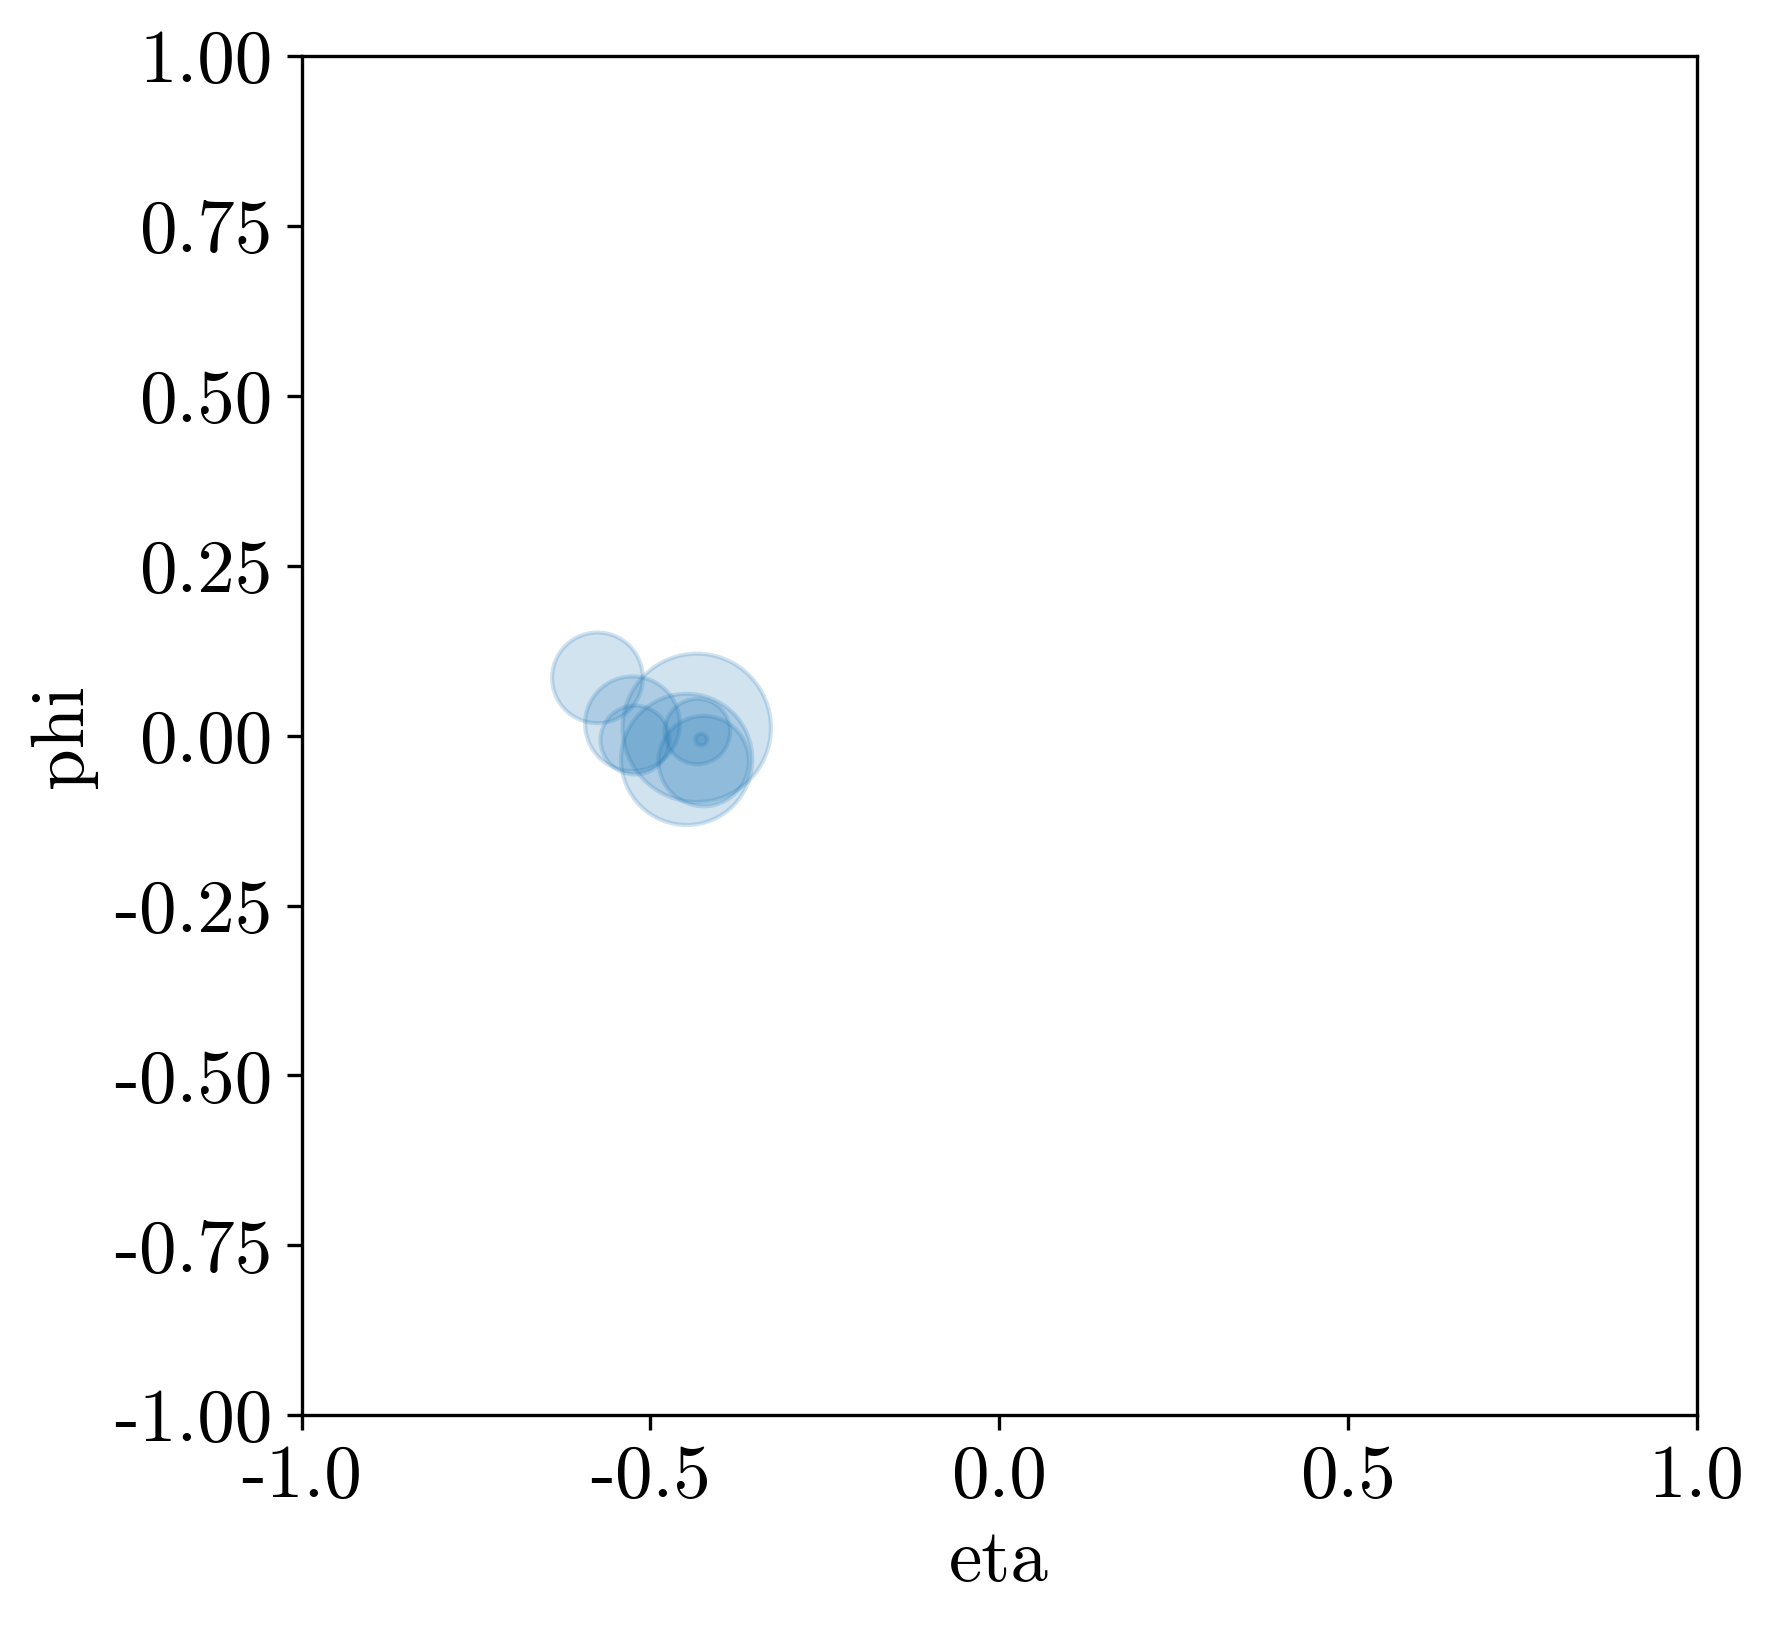

In [55]:
plot_event(data_sig_3p_8part[99].reshape(-1,3), "top_3p_8part")

In [ ]:
start = time.time()
data_sig_2p_2part = sig_2p_2part.generate_dataset(100)
end = time.time()
print(end-start)

In [ ]:
plot_event(data_sig_2p_2part[5].reshape(-1,3), "sig_2p_2part")

In [ ]:
sig_2p_3part = jet_data_generator("signal",0.00005, 2, 3)

In [ ]:
data_sig_2p_3part = sig_2p_3part.generate_dataset(100)


In [ ]:
plot_event(data_sig_2p_3part[5].reshape(-1,3), "sig_2p_3part")

In [ ]:
sig_3p_3part = jet_data_generator("signal",0.00005, 3, 3)

In [ ]:
data_sig_3p_3part = sig_3p_3part.generate_dataset(100)


In [ ]:
plot_event(data_sig_3p_3part[1].reshape(-1,3), "sig_3p_3part")

## 